In [7]:
%matplotlib inline
import numpy as np
import pylab as pl
import scipy.special as special
from scipy.integrate import quad
from scipy.integrate import nquad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
#pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'    

In [455]:
#want to plot the integrand in Eq. 60 of the paper
#with filled in values of I(...), delta(yn), 

#constants in natural units
#m = 1.
#c = 1.
theta_e = 10.
#nu_c = 1
#B = 10.
#e = 1


#constants in Gaussian cgs units (values from harmony)
m = 9.1093826e-28
c = 2.99792458e10
e = 4.80320680e-10
B = 30.0
n_e = 1.




#variables to be set (frequency, observer angle, width of delta function, electron number density, 
# sum index n)


theta = np.pi/3.
epsilon = 0.01
n_e = 1
nu_c = e * B / (2. * np.pi * m * c)
nu = 700000 * nu_c
nu_s = (2./9.) * nu_c * theta_e**2 * np.sin(theta)
n_e_nt = 1.
#p_PL = 2.2
p_PL = 3.
gamma_50_min = 1.
gamma_50_max = 1000.
#gamma_50_max = 100.
C = 1.
n_dn = (nu / nu_c) * abs(np.sin(theta))
Index_cutoff = 0.001
kappa = 3.5
gamma_cutoff = 1000.

In [459]:
def K_s(n, gamma):
    beta = np.sqrt(1. - 1./gamma**2.)
    cos_xi = (gamma * nu - n * nu_c) / (gamma * nu * beta * np.cos(theta))
    M = (np.cos(theta) - beta * cos_xi)/np.sin(theta)
    N = beta * np.sqrt(1. - cos_xi**2)
    z = (nu * gamma * beta * np.sin(theta) * np.sqrt(1. - cos_xi**2))/nu_c
    K_xx = M**2 * (special.jv(n, z))**2
    K_yy = N**2 * (special.jvp(n, z, 1))**2
    ans = K_xx + K_yy
    return ans

def kappa_body_with_cutoff_no_norm(gamma):
#    kappa_body = (1. + (np.sqrt(1. + m**2 * c**2 * (gamma**2 - 1.)) - 1.)/(kappa * theta_e))**(- kappa - 1.)
    kappa_body = (1. + (gamma - 1.)/(kappa * theta_e))**(- kappa - 1.)
    kappa_cutoff = np.exp(- gamma/gamma_cutoff)
    kappa_here = kappa_body * kappa_cutoff
    return kappa_here

def kappa_with_normalization_extra_term(gamma):
    kappa_prefactor = 4. * np.pi * m**3 * c**3 * gamma * np.sqrt(gamma**2 - 1.)
    kappa_here_1 = kappa_body_with_cutoff_no_norm(gamma) * kappa_prefactor
    return kappa_here_1

kappa_norm_value = quad(kappa_with_normalization_extra_term, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0]
#print kappa_norm

def kappa_with_cutoff_with_norm(gamma):
    kappa_dist = (1./kappa_norm_value) * kappa_body_with_cutoff_no_norm(gamma)
    return kappa_dist

def I_in_eq62(gamma, n):
    
    beta = np.sqrt(1. - 1./gamma**2.)
    cos_xi = (gamma * nu - n * nu_c) / (gamma * nu * beta * np.cos(theta))
    
    prefactor_Jnu = 2. * np.pi * e**2 * nu**2 / c
    d_3_p = m**3 * c**3 * gamma**2 * beta * 2 * np.pi
    
    ans = prefactor_Jnu * kappa_with_cutoff_with_norm(gamma) * d_3_p * K_s(n, gamma)
    
    return ans

def gamma_up_limit(n):
    gamma_up_nume = (n * nu_c /nu) + np.absolute(np.cos(theta)) * np.sqrt((n * nu_c /nu)**2 - (np.sin(theta))**2)
    gamma_deno = (np.sin(theta))**2
    gamma_up = gamma_up_nume / gamma_deno
    return gamma_up

def gamma_dn_limit(n):
    gamma_dn_nume = (n * nu_c /nu) - np.absolute(np.cos(theta)) * np.sqrt((n * nu_c /nu)**2 - (np.sin(theta))**2)
    gamma_deno = (np.sin(theta))**2
    gamma_dn = gamma_dn_nume / gamma_deno
    return gamma_dn
    
def jnu_integrand_in_eq62(gamma, n):
    
    beta = np.sqrt(1. - 1./gamma**2.)
    cos_xi = (gamma * nu - n * nu_c) / (gamma * nu * beta * np.cos(theta))
    
    prefactor_62 = 1. / (nu * beta * np.absolute(np.cos(theta)))
    
    f = prefactor_62 * I_in_eq62(gamma, n)
    
    return f

def jnu_n_integral_62_one(n):
    
    def jnu_integrand_in_eq62_gamma(gamma):
        jnu_integrand_62 = jnu_integrand_in_eq62(gamma, n)
        return jnu_integrand_62
    
    ans_once = quad(jnu_integrand_in_eq62_gamma, gamma_dn_limit(n), gamma_up_limit(n), epsabs = 0, epsrel = 1e-8)[0]
    
    return ans_once

n_peak = 1800000000

def jnu_62_integral_from_n_max_to_n_limit(n_max, n_dn):
    
    if(n_max < n_dn):
        n_max = n_dn
    
    ans = quad(jnu_n_integral_62_one, n_max, C * n_peak, epsabs = 0, epsrel = 1e-8)[0]
    
    return ans
    

def jnu_62_sum_to_n_max_integral_to_n_limit(n_max_sum):
    ans = 0
    for i in range(int(n_dn + 1.), int(1 + n_dn + n_max_sum)):
        ans = ans + jnu_n_integral_62_one(i)
#        print ans
        
    total = ans + jnu_62_integral_from_n_max_to_n_limit(n_max_sum, n_dn)
    return total
#print nu_s, nu_c

In [460]:
n_max = 1000
print jnu_62_sum_to_n_max_integral_to_n_limit(n_max)

1.01740324868e-23


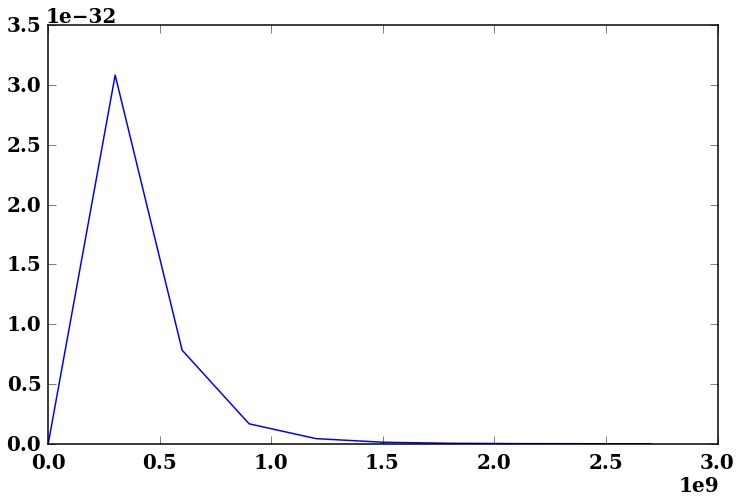

In [458]:
x_value = []
y_value = []

n_max_here = 3000000000

step = int((int(n_max_here))/10.)


for i in xrange(int(n_dn + 1.), int(n_dn + 1. + n_max_here), step):
    x_value = x_value + [i]
    y_value = y_value + [jnu_n_integral_62_one(i)]

#    print int(n_dn + 1.), x_value
pl.plot(x_value, y_value)
#print x_value, int(n_dn+1) 
#pl.xlim([0,4000])

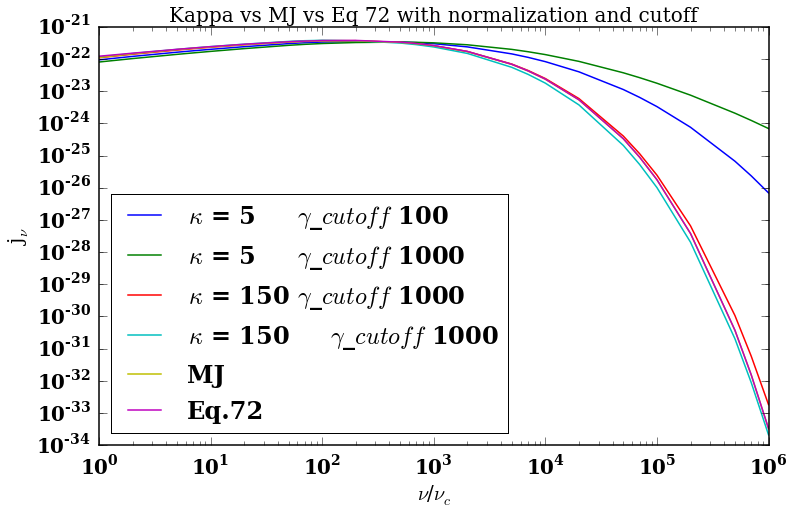

In [155]:
data1 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_150_with_cutoff1000_with_norm.txt')
data2 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/thermal_data_varing_nu.txt')
data3 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff1000_with_norm.txt')
data4 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff100_with_norm.txt')
data5 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_150_with_cutoff100_with_norm.txt')



def jnu_72(x):
    jnu_72_prefactor = n_e * np.sqrt(2) * np.pi * e**2 * nu_s / (3. * special.kn(2., 1./theta_e) * c)
    jnu_72_body = (np.sqrt(x/nu_s) + 2.**(11./12.) * (x/nu_s)**(1./6.))**2
    jnu_72_exp = np.exp(- (x/nu_s)**(1./3.))
    jnu_approximation_72 = jnu_72_prefactor * jnu_72_body * jnu_72_exp
    
    return jnu_approximation_72

#x = np.arange(1*nu_c, 1000000*nu_c, 10000)

jnu_72_outputs = jnu_72(nu_c * data1[:,0])

#print jnu_72_outputs

pl.xlabel("$\\nu$/$\\nu_c$")
pl.ylabel("j$_\\nu$")


pl.loglog(data4[:, 0], data4[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 100')
pl.loglog(data3[:, 0], data3[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 1000')
pl.loglog(data1[:, 0], data1[:, 1], label = '$\\kappa$ = 150 $\\gamma$_$cutoff$ 1000')
pl.loglog(data5[:, 0], data5[:, 1], label = '$\\kappa$ = 150     $\\gamma$_$cutoff$ 1000')
pl.loglog(data2[:, 0], data2[:, 1], label = 'MJ', color = 'y')
pl.loglog(data1[:,0], jnu_72_outputs, label = 'Eq.72')
pl.title("Kappa vs MJ vs Eq 72 with normalization and cutoff")

pl.legend(loc='lower left')
pl.show()

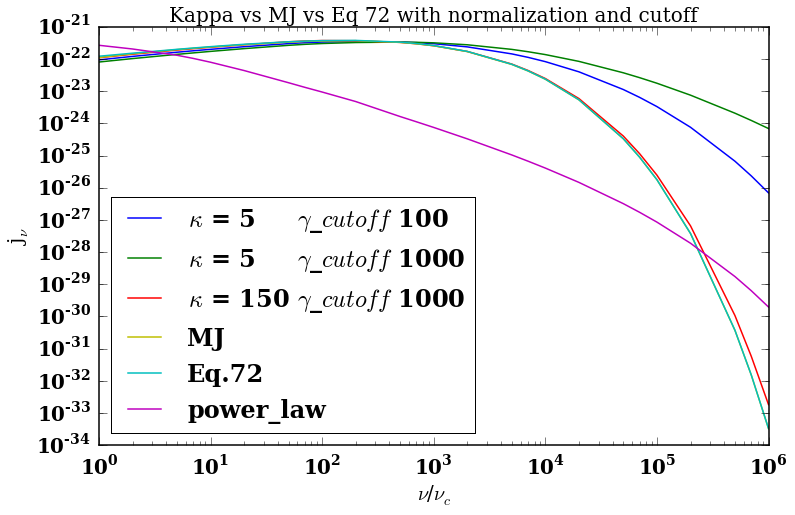

In [15]:
data1 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_150_with_cutoff1000_with_norm.txt')
data2 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/thermal_data_varing_nu.txt')
data3 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff1000_with_norm.txt')
data4 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff100_with_norm.txt')
data_power_law = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/power_law_w_cutoff100_norm_B30.txt')



def jnu_72(x):
    jnu_72_prefactor = n_e * np.sqrt(2) * np.pi * e**2 * nu_s / (3. * special.kn(2., 1./theta_e) * c)
    jnu_72_body = (np.sqrt(x/nu_s) + 2.**(11./12.) * (x/nu_s)**(1./6.))**2
    jnu_72_exp = np.exp(- (x/nu_s)**(1./3.))
    jnu_approximation_72 = jnu_72_prefactor * jnu_72_body * jnu_72_exp
    
    return jnu_approximation_72

#x = np.arange(1*nu_c, 1000000*nu_c, 10000)

jnu_72_outputs = jnu_72(nu_c * data1[:,0])

#print jnu_72_outputs

pl.xlabel("$\\nu$/$\\nu_c$")
pl.ylabel("j$_\\nu$")

pl.loglog(data4[:, 0], data4[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 100')
pl.loglog(data3[:, 0], data3[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 1000')
pl.loglog(data1[:, 0], data1[:, 1], label = '$\\kappa$ = 150 $\\gamma$_$cutoff$ 1000')
pl.loglog(data2[:, 0], data2[:, 1], label = 'MJ', color = 'y')
pl.loglog(data1[:,0], jnu_72_outputs, label = 'Eq.72')
pl.loglog(data_power_law[:,0], data_power_law[:,1], label = 'power_law')


pl.title("Kappa vs MJ vs Eq 72 with normalization and cutoff")

pl.legend(loc='lower left')
pl.show()

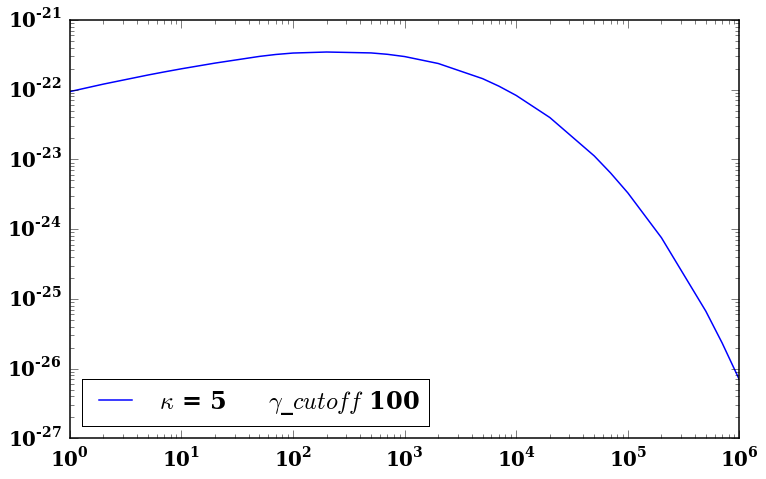